**Imports**

In [1]:
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt

from functions.retro_data.weather_data import get_weather
from functions.retro_data.spotprice_data import get_spotprice
from functions.retro_data.consumption_data import get_demand
from functions.calculations.calculations import calculate_energy
from functions.calculations.kpis import calculate_kpis
from functions.deciding_functions.optimized import optimize_energy_flow
from functions.deciding_functions.reinforcementlearning import reinforcement_learning
from functions.deciding_functions.rulebased import rule_based_energy_flow

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


**Definition des Green Energy Ecosystems**

In [2]:
# Photovoltaik
solar_peak_power = 38  # Spitzenleistung Gesamtsystem PV [MW]
num_modules = 114980 #Anzahl Solarmodule
area_per_module = 1.57458  # Fläche pro Modul [m²] (Annahme Heckert Solar NeMo® 2.0 330 Wp)
module_efficiency = 0.196  # Wirkungsgrad der Solarmodule (Annahme Heckert Solar NeMo® 2.0 330 Wp)
tilt_angle = 45  # Neigungswinkel der Solarpanels [°] (Annahme)
latitude=51.751111 
longitude=4.208611 
azimuth=180 
albedo=0.2 

# Windkraft 
wind_peak_power = 22   # Spitzenleistung Gesamtsystem Windkraft [MW]
r = 60 # Rotor Radius [m]
h = 90 # Höhe Windrad [m]
turbine_efficiency = 0.5  # Wirkungsgrad der Windkraftanlagen (Annahme)
cut_in = 2.5  # Einschaltgeschwindigkeit [m/s]
cut_out = 28  # Abschaltgeschwindigkeit [m/s]
num_turbines = 6 # Anzahl Windkraftanlagen

# Batteriespeicher
battery_capacity = 12  # MWh
soc = 0.5  # State of Charge (SOC) initial [0-1]
initial_battery = soc * battery_capacity  # MWh
charging_rate = 10  # Lade-/Entladerate [MW/h]
discharging_rate = 10

# Verbraucher
yearly_demand = 2.7  #  Verbrauch eines Haushalts/Jahr [MWh] (Annahme)
num_houses = 39000  # Anzahl Haushalte

# Strompreis
export_factor = 0.25   # Anteil vom Spotpreis für Einspeisung
price_low_quant  = 0.30   # Regelbasiert: Niedrigpreis-Schwelle

# Parameter für Sliding Window
start_month = 5  # Startmonat für das Sliding Window (1 bis 12)
start_year = 2025  # Startjahr für das Sliding Window (2024/2025)
cut_ds = 14  # Datensatz kürzen [Tage]
window_days = 7    # Länge des Fensters [Tage]
step_hours = 1    # Schrittweite [Stunden]

#RL Parameter
split = 80/20

**Ausführen der Vorbereitungsfunktionen**

In [3]:
# Daten laden
df_weather = get_weather()
df_spot = get_spotprice()
df_demand = get_demand(num_houses, yearly_demand)
if df_weather is None or df_spot is None or df_demand is None:
    print("Abbruch.")

for df in [df_weather, df_spot, df_demand]:
    df["datetime"] = pd.to_datetime(df["datetime"])

# Liegt das Startdatum im erlaubten Zeitraum?
if (start_month < 1) or (start_month > 12) or (start_year < 2024) or (start_year > 2025) or (start_year == 2025 and start_month > 5):
    raise ValueError("Startmonat/-jahr liegt außerhalb des erlaubten Zeitraums (01.01.2024 bis 31.05.2025).")
    
# Zuschneiden der Datensätze auf gewünschten Monat und Jahr
first_of_month = df_weather[
    (df_weather["datetime"].dt.month == start_month) &
    (df_weather["datetime"].dt.year == start_year)
]["datetime"].min()
if pd.isnull(first_of_month):
    raise ValueError(f"Kein Datenpunkt für Monat {start_month} und Jahr {start_year} im Datensatz gefunden.")

start = first_of_month
end = start + pd.Timedelta(days=cut_ds)

df_weather = df_weather[(df_weather["datetime"] >= start) & (df_weather["datetime"] < end)].reset_index(drop=True)
df_spot = df_spot[(df_spot["datetime"] >= start) & (df_spot["datetime"] < end)].reset_index(drop=True)
df_demand = df_demand[(df_demand["datetime"] >= start) & (df_demand["datetime"] < end)].reset_index(drop=True)

display(df_weather.head())
print(len(df_weather))

display(df_spot.head())
print(len(df_spot))

display(df_demand.head())
print(len(df_demand))

,datetime,solarradiation,windspeed,temp,cloudcover,humidity,sealevelpressure
0,2025-05-01 00:00:00,0.0,6.7,14.2,3.9,81.94,1021.0
1,2025-05-01 01:00:00,0.0,6.1,13.8,30.0,85.49,1020.9
2,2025-05-01 02:00:00,0.0,6.2,12.9,100.0,90.00,1020.6
3,2025-05-01 03:00:00,0.0,6.1,11.7,65.0,93.30,1020.5
4,2025-05-01 04:00:00,0.0,5.5,11.4,61.2,94.96,1020.3


336


,datetime,spotprice
0,2025-05-01 00:00:00,97.51
1,2025-05-01 01:00:00,91.78
2,2025-05-01 02:00:00,90.46
3,2025-05-01 03:00:00,90.63
4,2025-05-01 04:00:00,90.50


336


,datetime,energy_demand
0,2025-05-01 00:00:00,9.325286
1,2025-05-01 01:00:00,8.906397
2,2025-05-01 02:00:00,8.604250
3,2025-05-01 03:00:00,8.411361
4,2025-05-01 04:00:00,8.327844


336


**Ausführen der Berechnungsfunktion**

In [4]:
# Bedarf und Ertrag berechnen
df_energy = calculate_energy(
df_weather, 
solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines
)

display(df_energy.head())

,datetime,windspeed,poa_irradiance,solar_energy_production,wind_energy_production,total_energy_production
0,2025-05-01 00:00:00,6.7,0.0,0.0,0.0,0.0
1,2025-05-01 01:00:00,6.1,0.0,0.0,0.0,0.0
2,2025-05-01 02:00:00,6.2,0.0,0.0,0.0,0.0
3,2025-05-01 03:00:00,6.1,0.0,0.0,0.0,0.0
4,2025-05-01 04:00:00,5.5,0.0,0.0,0.0,0.0


**Datensätze mergen und splitten**

In [5]:
# Merge aller drei DataFrames zu einem Testdatensatz
df_test = df_energy.merge(
    df_spot[['datetime', 'spotprice']],
    on='datetime', how='left'
).merge(
    df_demand[['datetime', 'energy_demand']],
    on='datetime', how='left'
)

In [6]:
# Trainingsdaten für RL: Zeitraum vor dem Testzeitraum aus den Rohdaten!
train_end = df_test["datetime"].min()
train_start = train_end - pd.Timedelta(days=cut_ds*split)

# Hier die Rohdaten verwenden, nicht die gekürzten!
df_train_weather = get_weather()
df_train_spot = get_spotprice()
df_train_demand = get_demand(num_houses, yearly_demand)

for df in [df_train_weather, df_train_spot, df_train_demand]:
    df["datetime"] = pd.to_datetime(df["datetime"])

df_train_weather = df_train_weather[(df_train_weather["datetime"] >= train_start) & (df_train_weather["datetime"] < train_end)].reset_index(drop=True)
df_train_spot = df_train_spot[(df_train_spot["datetime"] >= train_start) & (df_train_spot["datetime"] < train_end)].reset_index(drop=True)
df_train_demand = df_train_demand[(df_train_demand["datetime"] >= train_start) & (df_train_demand["datetime"] < train_end)].reset_index(drop=True)

df_energy_train = calculate_energy(
    df_train_weather, 
    solar_peak_power, num_modules, area_per_module, module_efficiency, tilt_angle, latitude, longitude, azimuth, albedo, 
    wind_peak_power, r, h, turbine_efficiency, cut_in, cut_out, num_turbines
)
df_train = df_energy_train.merge(
    df_train_spot[['datetime', 'spotprice']],
    on='datetime', how='left'
).merge(
    df_train_demand[['datetime', 'energy_demand']],
    on='datetime', how='left'
).reset_index(drop=True)

**Plot der Energiedaten und relevanten Wetterdaten**

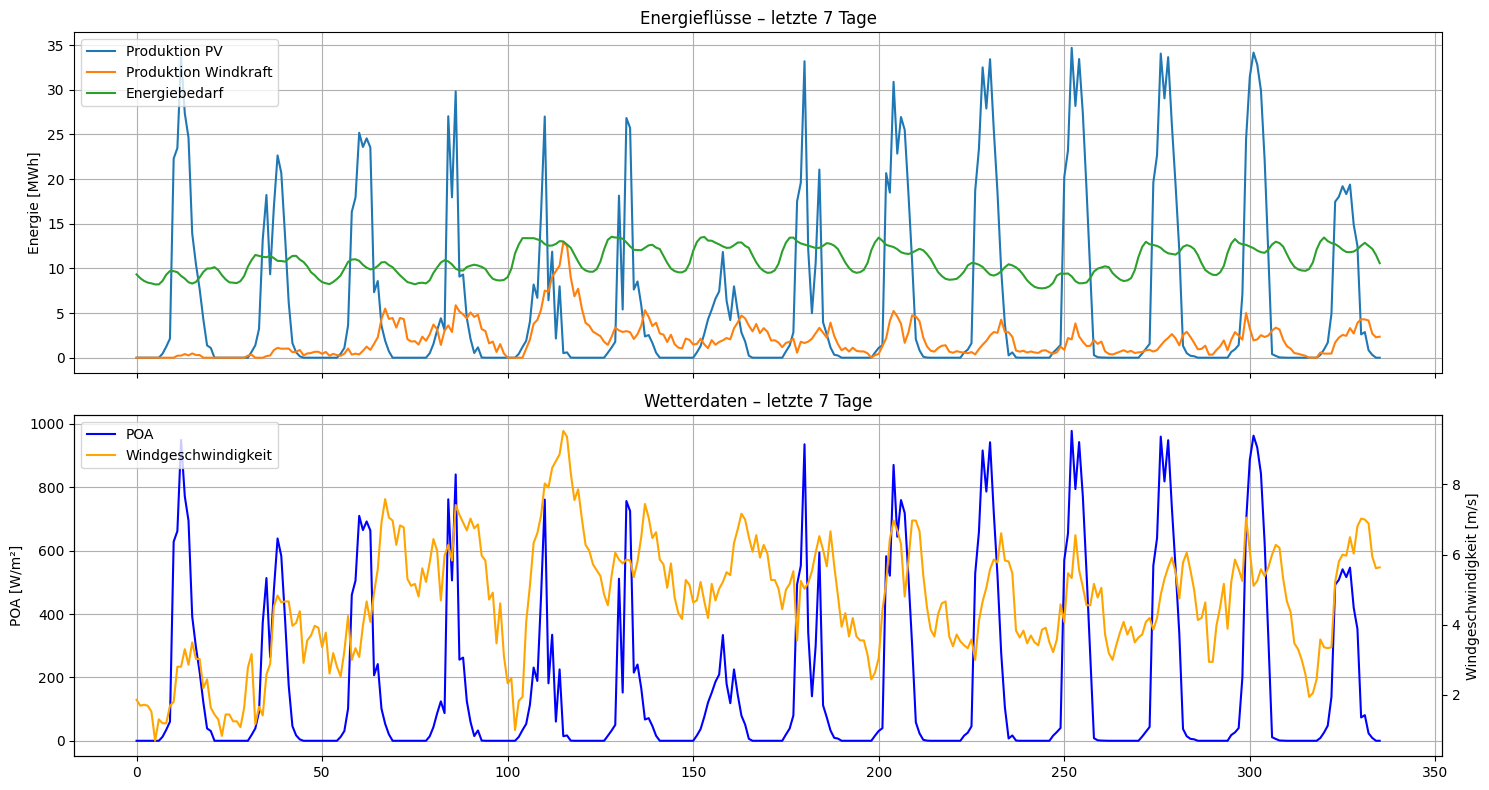

In [7]:
df_plot = df_test.copy()

# Figure mit zwei Subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Energieflüsse
ax1.plot(df_plot.index, df_plot["solar_energy_production"], label="Produktion PV")
ax1.plot(df_plot.index, df_plot["wind_energy_production"], label="Produktion Windkraft")
ax1.plot(df_plot.index, df_plot["energy_demand"], label="Energiebedarf")
ax1.set_ylabel("Energie [MWh]")
ax1.set_title("Energieflüsse – letzte 7 Tage")
ax1.legend()
ax1.grid(True)

# Wetterdaten
ax2a = ax2  # linke Achse
ax2b = ax2a.twinx()  # rechte Achse

line1, = ax2a.plot(df_plot.index, df_plot["poa_irradiance"], color="blue", label="POA")
line2, = ax2b.plot(df_plot.index, df_plot["windspeed"] / 3.6, color="orange", label="Windgeschwindigkeit")

ax2a.set_ylabel("POA [W/m²]")
ax2a.tick_params(axis='y')
ax2b.set_ylabel("Windgeschwindigkeit [m/s]")
ax2b.tick_params(axis='y')
ax2a.set_title("Wetterdaten – letzte 7 Tage")

# Gemeinsame Legende unten
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax2.grid(True)
ax2a.legend(lines, labels, loc="upper left")

plt.xlabel("Zeit")
plt.tight_layout()
plt.show()


**Ausführen der regelbasierten und optimierten Funktion**

In [8]:
result_df_rule = rule_based_energy_flow(
    df_test, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, price_low_quant
    )

result_df_opt = optimize_energy_flow(
    df_test, 
    battery_capacity, initial_battery, charging_rate, discharging_rate,
    export_factor, 
    window_days, step_hours
    )

result_df_rl = reinforcement_learning(
    df_train,
    df_test,
    battery_capacity,
    initial_battery,
    charging_rate,
    discharging_rate,
    export_factor,
    window_days,
    step_hours,
    total_timesteps=10000
)

result_kpis_rule = calculate_kpis(result_df_rule, export_factor)
result_kpis_opt = calculate_kpis(result_df_opt, export_factor)
result_kpis_rl = calculate_kpis(result_df_rl, export_factor)

**Ausgabe der wichtigsten KPIs zum quanitiativen Vergleich der Performance**

In [9]:
#Ausgaben 
print("Regelbasiert:")
print(f"Netto Stromkosten: {result_kpis_rule['Netto Stromkosten']:.2f} €")
print(f"Netzstromkosten: {result_kpis_rule['Netzstromkosten']:.2f} €")
print(f"Einspeisevergütung: {result_kpis_rule['Einspeisevergütung']:.2f} €")
wavg_price_rule = (result_df_rule["spotprice_EUR_per_MWh"] * result_df_rule["ee_export_MWh"]).sum() / max(result_kpis_rule["Einspeisung"], 1e-9)
print(f"Export-gewichteter Preis (rule): {wavg_price_rule:.2f} €/MWh")
print(f"Netzbezug: {result_kpis_rule['Netzbezug']:.2f} MWh")
print(f"Einspeisung: {result_kpis_rule['Einspeisung']:.2f} MWh")
print(f"Batterieladung: {result_kpis_rule['Batterieladung']:.2f} MWh")
print(f"Batterieentladung: {result_kpis_rule['Batterieentladung']:.2f} MWh")

print("----------------------")

print("Optimiert:")
print(f"Netto Stromkosten: {result_kpis_opt['Netto Stromkosten']:.2f} €")
print(f"Netzstromkosten: {result_kpis_opt['Netzstromkosten']:.2f} €")
print(f"Einspeisevergütung: {result_kpis_opt['Einspeisevergütung']:.2f} €")
wavg_price_opt = (result_df_opt["spotprice_EUR_per_MWh"] * result_df_opt["ee_export_MWh"]).sum() / max(result_kpis_opt["Einspeisung"], 1e-9)
print(f"Export-gewichteter Preis (opt):  {wavg_price_opt:.2f} €/MWh")
print(f"Netzbezug: {result_kpis_opt['Netzbezug']:.2f} MWh")
print(f"Einspeisung: {result_kpis_opt['Einspeisung']:.2f} MWh")
print(f"Batterieladung: {result_kpis_opt['Batterieladung']:.2f} MWh")
print(f"Batterieentladung: {result_kpis_opt['Batterieentladung']:.2f} MWh")

print("----------------------")

print("Reinforcement Learning:")
print(f"Netto Stromkosten: {result_kpis_rl['Netto Stromkosten']:.2f} €")
print(f"Netzstromkosten: {result_kpis_rl['Netzstromkosten']:.2f} €")
print(f"Einspeisevergütung: {result_kpis_rl['Einspeisevergütung']:.2f} €")
wavg_price_rl = (result_df_rl["spotprice_EUR_per_MWh"] * result_df_rl["ee_export_MWh"]).sum() / max(result_kpis_rl["Einspeisung"], 1e-9)
print(f"Export-gewichteter Preis (RL):  {wavg_price_rl:.2f} €/MWh")
print(f"Netzbezug: {result_kpis_rl['Netzbezug']:.2f} MWh")
print(f"Einspeisung: {result_kpis_rl['Einspeisung']:.2f} MWh")
print(f"Batterieladung: {result_kpis_rl['Batterieladung']:.2f} MWh")
print(f"Batterieentladung: {result_kpis_rl['Batterieentladung']:.2f} MWh")

print("----------------------")

# Differenz Optimiert - Regelbasiert
diff_eur = result_kpis_opt["Netto Stromkosten"] - result_kpis_rule["Netto Stromkosten"]
rel_pct  = diff_eur / result_kpis_rule["Netto Stromkosten"] * 100
demand_MWh = result_df_opt["demand_MWh"].sum()  # Referenz für ct/kWh

print(f"Einsparungspotenzial: {diff_eur:.2f} € ({rel_pct:.2f} %)")
months = len(df_weather) / 24
saving_per_month = diff_eur / months
print(f"Ø tägliche Einsparung: {saving_per_month:.2f} €")



Regelbasiert:
Netto Stromkosten: 185721.79 €
Netzstromkosten: 177433.70 €
Einspeisevergütung: -8288.08 €
Export-gewichteter Preis (rule): -32.56 €/MWh
Netzbezug: 1880.11 MWh
Einspeisung: 1018.18 MWh
Batterieladung: 195.35 MWh
Batterieentladung: 201.35 MWh
----------------------
Optimiert:
Netto Stromkosten: 148363.29 €
Netzstromkosten: 135525.66 €
Einspeisevergütung: -12837.63 €
Export-gewichteter Preis (opt):  -31.20 €/MWh
Netzbezug: 2499.67 MWh
Einspeisung: 1645.98 MWh
Batterieladung: 395.88 MWh
Batterieentladung: 401.88 MWh
----------------------
Reinforcement Learning:
Netto Stromkosten: 171089.57 €
Netzstromkosten: 173291.19 €
Einspeisevergütung: 2201.62 €
Export-gewichteter Preis (RL):  63.84 €/MWh
Netzbezug: 2623.55 MWh
Einspeisung: 137.94 MWh
Batterieladung: 36.67 MWh
Batterieentladung: 38.39 MWh
----------------------
Einsparungspotenzial: -37358.49 € (-20.12 %)
Ø tägliche Einsparung: -2668.46 €


**Plot der Energieflüsse zum qualitativen Vergleich der Performance**

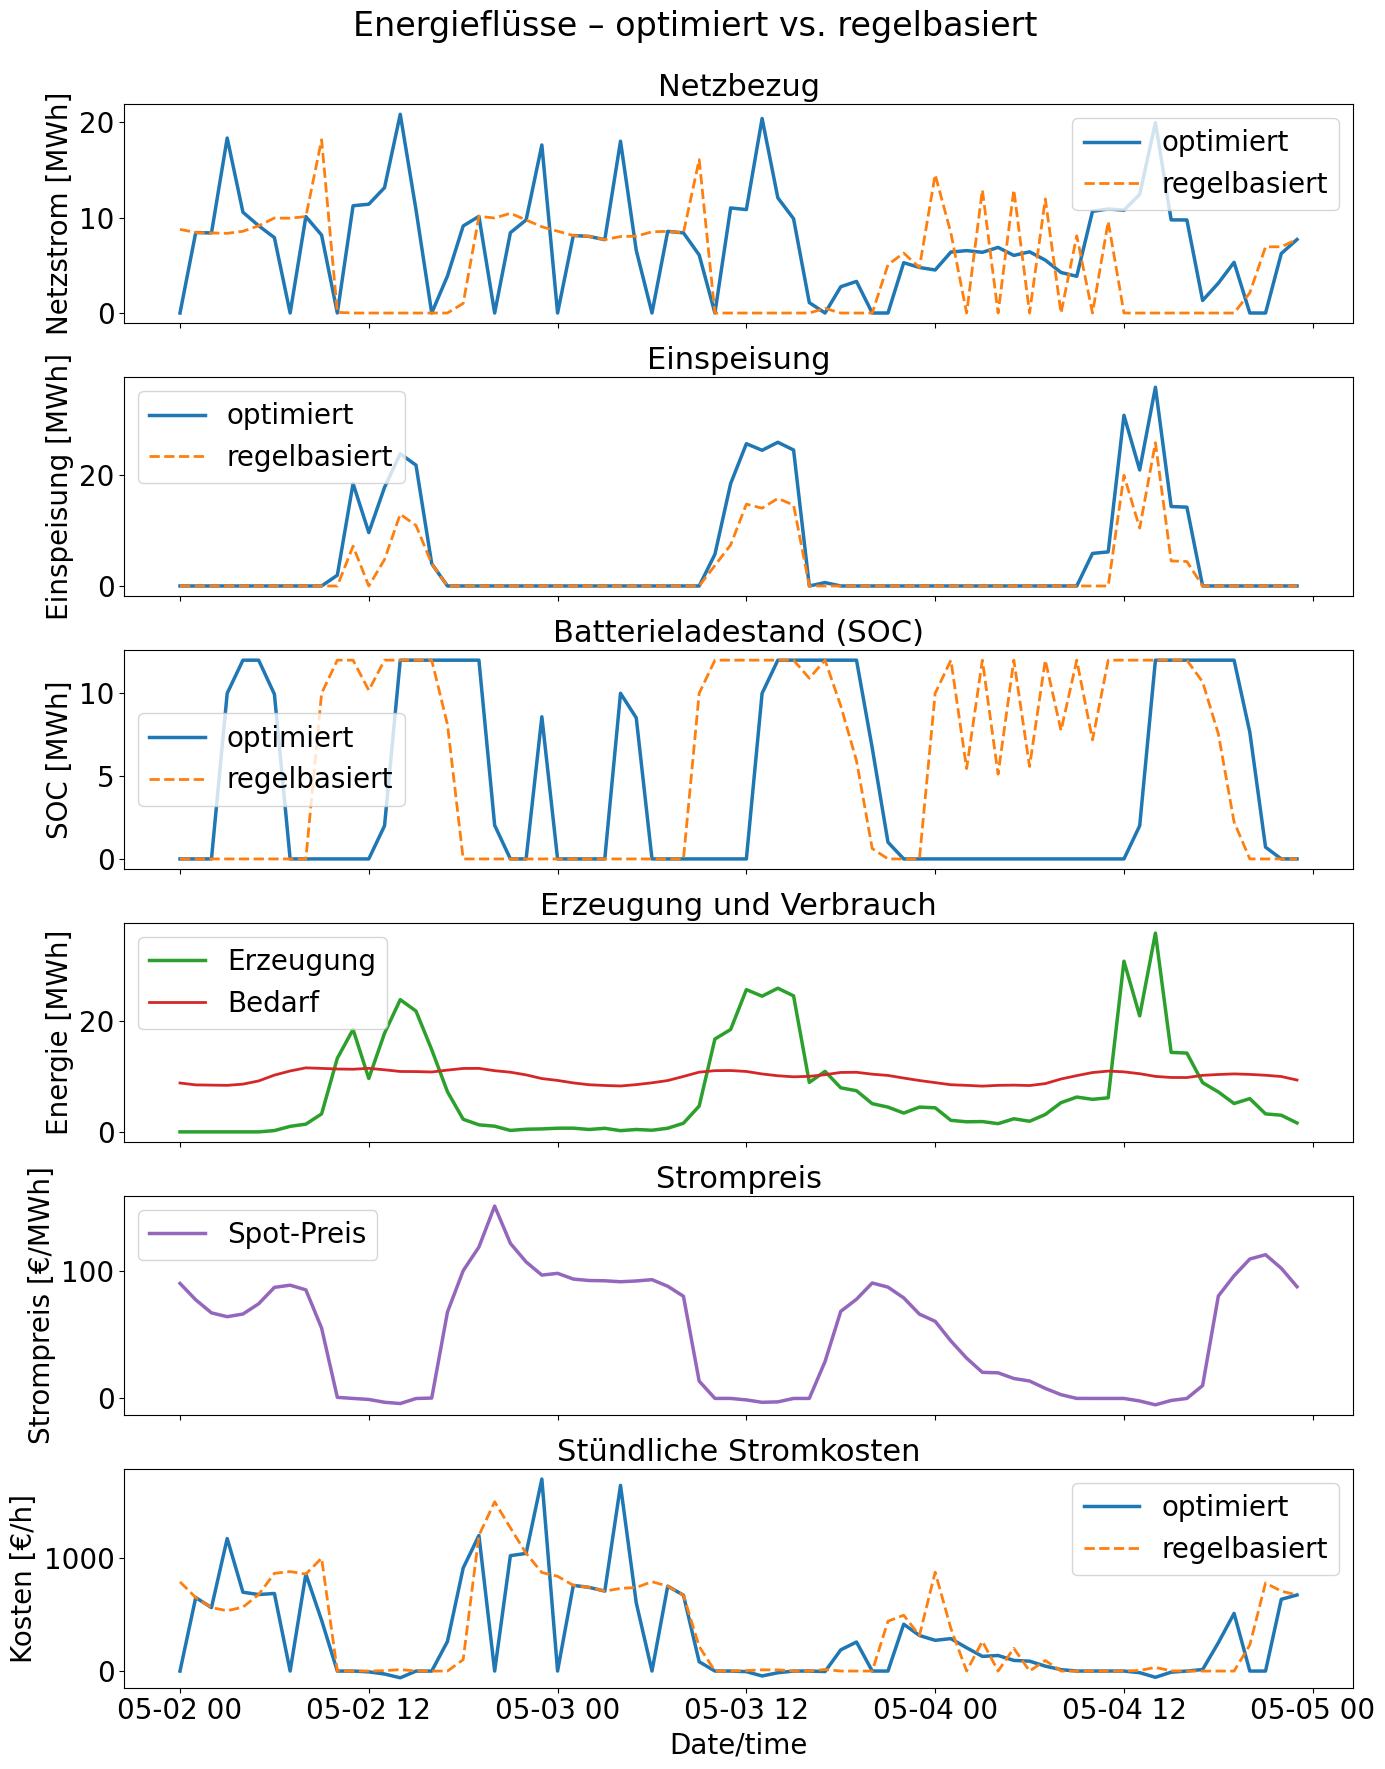

In [10]:
# Zeitspalten
result_df_opt["datetime"] = pd.to_datetime(result_df_opt["datetime"])
result_df_rule["datetime"] = pd.to_datetime(result_df_rule["datetime"])

# Kopien + Hilfsspalten
opt  = result_df_opt.copy()
rule = result_df_rule.copy()
for df in (opt, rule):
    df["grid_buy"]       = df["grid_to_load_MWh"] + df["grid_to_batt_MWh"]
    df["battery_state"]  = df["SOC_MWh"]
    df["grid_feed_in"]   = df["ee_export_MWh"]
    # stündliche Kosten (€/h)
    df["hourly_cost_EUR"] = (
        (df["grid_to_load_MWh"] + df["grid_to_batt_MWh"]) * df["spotprice_EUR_per_MWh"]
        - export_factor * df["ee_export_MWh"] * df["spotprice_EUR_per_MWh"]
    )

# Zeitfenster
start_time = opt["datetime"].min() + pd.Timedelta(days=1)
end_time   = start_time + pd.Timedelta(days=3)
opt  = opt[(opt["datetime"] >= start_time) & (opt["datetime"] < end_time)]
rule = rule[(rule["datetime"] >= start_time) & (rule["datetime"] < end_time)]

# Styles
label_fontsize = 20
tick_fontsize  = 20
legend_fontsize= 20
title_fontsize = 22
c_opt  = "tab:blue"
c_rule = "tab:orange"
c_gen  = "tab:green"
c_dem  = "tab:red"
c_prc  = "tab:purple"

# Plot (jetzt 6 Panels inkl. Kosten)
fig, axs = plt.subplots(6, 1, figsize=(14, 18), sharex=True)
fig.suptitle("Energieflüsse – optimiert vs. regelbasiert", fontsize=title_fontsize+2)

# 1) Netzbezug
axs[0].set_title("Netzbezug", fontsize=title_fontsize)
axs[0].plot(opt["datetime"],  opt["grid_buy"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[0].plot(rule["datetime"], rule["grid_buy"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[0].set_ylabel("Netzstrom [MWh]", fontsize=label_fontsize)
axs[0].legend(fontsize=legend_fontsize)
axs[0].tick_params(axis='both', labelsize=tick_fontsize)

# 2) Einspeisung
axs[1].set_title("Einspeisung", fontsize=title_fontsize)
axs[1].plot(opt["datetime"],  opt["grid_feed_in"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[1].plot(rule["datetime"], rule["grid_feed_in"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[1].set_ylabel("Einspeisung [MWh]", fontsize=label_fontsize)
axs[1].legend(fontsize=legend_fontsize)
axs[1].tick_params(axis='both', labelsize=tick_fontsize)

# 3) Batteriezustand
axs[2].set_title("Batterieladestand (SOC)", fontsize=title_fontsize)
axs[2].plot(opt["datetime"],  opt["battery_state"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[2].plot(rule["datetime"], rule["battery_state"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[2].set_ylabel("SOC [MWh]", fontsize=label_fontsize)
axs[2].legend(fontsize=legend_fontsize)
axs[2].tick_params(axis='both', labelsize=tick_fontsize)

# 4) Erzeugung und Verbrauch
axs[3].set_title("Erzeugung und Verbrauch", fontsize=title_fontsize)
axs[3].plot(opt["datetime"], opt["EE_total_MWh"], label="Erzeugung", color=c_gen, linewidth=2.5)
axs[3].plot(opt["datetime"], opt["demand_MWh"],     label="Bedarf",    color=c_dem, linewidth=2)
axs[3].set_ylabel("Energie [MWh]", fontsize=label_fontsize)
axs[3].legend(fontsize=legend_fontsize)
axs[3].tick_params(axis='both', labelsize=tick_fontsize)

# 5) Strompreis
axs[4].set_title("Strompreis", fontsize=title_fontsize)
axs[4].plot(opt["datetime"], opt["spotprice_EUR_per_MWh"], label="Spot-Preis", color=c_prc, linewidth=2.5)
axs[4].set_ylabel("Strompreis [€/MWh]", fontsize=label_fontsize)
axs[4].legend(fontsize=legend_fontsize)
axs[4].tick_params(axis='both', labelsize=tick_fontsize)

# 6) Stündliche Stromkosten
axs[5].set_title("Stündliche Stromkosten", fontsize=title_fontsize)
axs[5].plot(opt["datetime"],  opt["hourly_cost_EUR"],  label="optimiert", color=c_opt, linewidth=2.5)
axs[5].plot(rule["datetime"], rule["hourly_cost_EUR"], label="regelbasiert", color=c_rule, linestyle="--", linewidth=2)
axs[5].set_ylabel("Kosten [€/h]", fontsize=label_fontsize)
axs[5].legend(fontsize=legend_fontsize)
axs[5].tick_params(axis='both', labelsize=tick_fontsize)

plt.xlabel("Date/time", fontsize=label_fontsize)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
